In [1]:
import numpy as np
import generative_model, generative_model_global
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import copy
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys, os
sys.path.append(os.path.dirname(sys.path[0]))

from discrepancies import datasets, pool2graph, discrepancies_intervals, fair_helpers, Grari_fair



In [2]:
#import dill
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

# Example of Fair classifier (with DNN)

In [3]:


X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset='adult')
sensitive_name = 'sex'

Z_train, Z_test = X_train[sensitive_name], X_test[sensitive_name]
Z_train, Z_test  = (Z_train > Z_train.mean()).astype('int'), (Z_test > Z_test.mean()).astype('int')
del X_train[sensitive_name]
del X_test[sensitive_name]
feature_names = [f for f in feature_names if f != sensitive_name]

print(feature_names)
print(X_train.shape, X_test.shape, y_train.mean(), Z_train.mean())

taking only 1000 instances
['capital-gain', 'age', 'capital-loss', 'education-num', 'hours-per-week']
(3350, 5) (1650, 5) 0.24238805970149255 0.6683582089552239


### Training a fair adversarial gradient boosting clf

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

## biased
gb = GradientBoostingClassifier(n_estimators=1000, learning_rate = 0.001, max_depth =8, max_features=None,random_state=0)
gb.fit(X_train.values, y_train.values)

## fair
clf = Grari_fair.GradientBoostingClassifier_AXA(n_estimators=1000, learning_rate=0.001, max_depth=8, max_features=None)
preds = clf.fit(X_train.values, y_train.values, LAMBDA=0.3, sensitive=Z_train.values, Xtest=X_test.values, yt=y_test.ravel(), sensitivet=Z_test.ravel())

## fair one unit
clf_1 = Grari_fair.GradientBoostingClassifier_AXA(n_estimators=1000, learning_rate=0.001, max_depth=8, max_features=None)
preds_1 = clf_1.fit(X_train.values, y_train.values, LAMBDA=0.1, sensitive=Z_train.values, Xtest=X_test.values, yt=y_test.ravel(), sensitivet=Z_test.ravel())




odds nan
odds nan
0 : param : [13.67221128] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
20 : param : [38.22000631] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
40 : param : [-11.38892952] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
60 : param : [10.81080529] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
80 : param : [38.98426097] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
100 : param : [-12.50311966] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
120 : param : [10.35034579] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
140 : param : [39.53100541] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
160 : param : [-13.54078385] Accuracy: 0.7576  tes

odds nan
440 : param : [40.10755849] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
460 : param : [-13.27829656] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
480 : param : [10.96282521] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
500 : param : [40.32168371] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
520 : param : [-13.62959828] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
540 : param : [10.84032463] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
560 : param : [40.51854745] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
580 : param : [-13.97857288] Accuracy: 0.7576  test :  0.763  Prule Train :  nan  Prule test :  nan
odds nan
odds nan
600 : param : [10.69879114] Accuracy: 0.7576  test :

The classifier has the following accuracy (test):0.835758
The classifier satisfies the following %p-rules:
odds 2.096616759037141
	given attribute sex;  48%-rule
The classifier has the following accuracy (test):0.820000
The classifier satisfies the following %p-rules:
odds 2.717925386715196
	given attribute sex;  37%-rule
The classifier has the following accuracy (test):0.822424
The classifier satisfies the following %p-rules:
odds 2.1580488190845433
	given attribute sex;  46%-rule


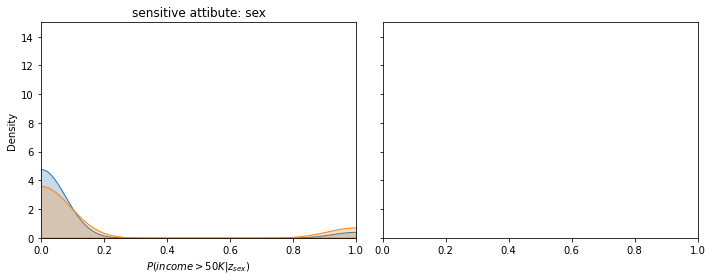

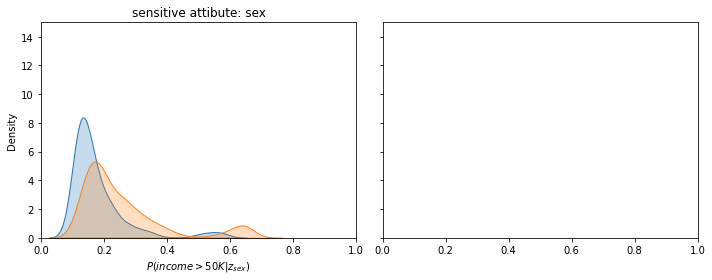

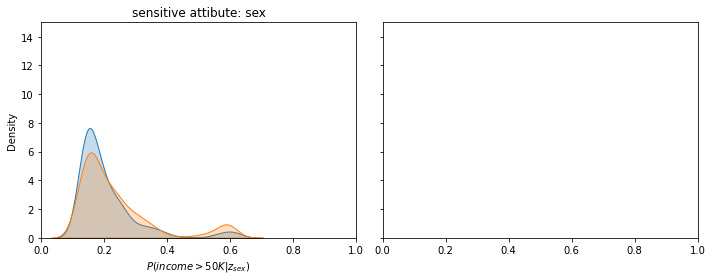

In [5]:
from sklearn.metrics import accuracy_score


y_pred2= gb.predict(X_test.values)
accuracy2 = accuracy_score(y_test.values, y_pred2)
print("The classifier has the following accuracy (test):%f"%accuracy2)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute sex;  {Grari_fair.p_rule(y_pred2, Z_test):.0f}%-rule")

fig = Grari_fair.plot_distributions(y_pred2, pd.DataFrame(Z_test))




yhat = clf.predict(X_test.values, Z_test.values)
accuracy = accuracy_score(y_test, yhat>0.5)
print("The classifier has the following accuracy (test):%f"%accuracy)

print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute sex;  {Grari_fair.p_rule(yhat, Z_test):.0f}%-rule")

fig = Grari_fair.plot_distributions(yhat, pd.DataFrame(Z_test))


yhat = clf_1.predict(X_test.values, Z_test.values)
accuracy = accuracy_score(y_test, yhat>0.5)
print("The classifier has the following accuracy (test):%f"%accuracy)

print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute sex;  {Grari_fair.p_rule(yhat, Z_test):.0f}%-rule")

fig = Grari_fair.plot_distributions(yhat, pd.DataFrame(Z_test))


In [ ]:
N_LAYERS = 5
N_NEURONS = 10
N_EPOCHS = 50

clf_biased = DNN_pool.Classifier(n_features=X_train.shape[1],
                n_hlayers=N_LAYERS,
                n_hidden=N_NEURONS)
clf_biased.fit(X_train, y_train, n_epochs=100, plot=True)

clf_dummy = DNN_pool.Classifier(n_features=X_train.shape[1], n_hlayers=N_LAYERS, n_hidden=N_NEURONS)
clf_fair = DNN_pool.FairZhang(clf_dummy, lambda_=5.8)
clf_fair.pretrain_both(X_train, Z_train, y_train, n_clf_epochs=100, n_adv_epochs=100)
clf_fair.fit(X_train, Z_train, y_train, plot=True, n_epochs=300)
#print("Adversarial MSE", (((clf_fair.predict_sensitive_adv(X_test).flatten() - Z_test))**2).meanTrue)
print("Clf accuracy biased", (clf_biased.predict(X_test) == y_test).mean())
#female_tox_rate, nf_tox_rate, female_tp_rate, nf_tp_rate, female_fp_rate, nf_fp_rate, demo_parity, tp_parity, fp_parity, equ_odds = DNN_pool.get_fairness_metrics(y_train, clf_biased.predict(X_train), Z_train, 1 - Z_train, 0.5)
print('ooooo')
print(clf_fair._eval())
print('Demographic Parity biased: %f ; Equalized Odds biased: %f'%(demo_parity, equ_odds))

print("Clf accuracy fair", (clf_fair.clf.predict(X_test) == y_test).mean())
female_tox_rate, nf_tox_rate, female_tp_rate, nf_tp_rate, female_fp_rate, nf_fp_rate, demo_parity, tp_parity, fp_parity, equ_odds = DNN_pool.get_fairness_metrics(y_train, clf_fair.clf.predict(X_train), Z_train, 1 - Z_train, 0.5)
print('Demographic Parity Fair: %f ; Equalized Odds Fair: %f'%(demo_parity, equ_odds))



# Discrepancy analysis with p2g

In [ ]:
%%time

pool1 = DNN_pool.ZhangPool(lambda_=5.0)
pool1.fit(X_train, Z_train, y_train, n_epochs=100)

p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=20)
p2g.fit(max_epochs=3)



In [ ]:
from sklearn.metrics import confusion_matrix


pd.DataFrame(confusion_matrix(pool1.predict(X_test).iloc[:, 0], pool1.predict(X_test).iloc[:, 1]), columns=['fair 0', 'fair 1'])



In [ ]:
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
len(intervals)

In [ ]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)

In [ ]:
sns.set_style()


ax = sns.barplot(data=global_interval_coord, ci=95, palette="Set2")
ax.set_xticklabels(X_train.columns,rotation=30)

plt.tight_layout()

In [ ]:
from sklearn.cluster import KMeans

oneborder = np.array([di.border_features.iloc[0] for di in intervals])
coord_intervals = []
for di in intervals:
    a, b = di.border_features.iloc[0], di.border_features.iloc[1]
    if a[0] > 0:
        interval_coord = a - b
    else:
        interval_coord = a - b
    coord_intervals.append(interval_coord)
coord_intervals = np.array(coord_intervals)
coord_intervals = pd.DataFrame(coord_intervals, columns=X_train.columns)

nodes = p2g.get_nodes_attributes(p2g.get_nodes(discrepancies=True))[0]

clusters_nodes = KMeans(n_clusters=6, n_jobs=-1).fit_predict(nodes)

clusters = clusters_nodes.copy()
data = nodes.copy()


data["cluster"] = clusters
print(data.groupby('cluster').count())

sns.catplot(data=data, col="cluster", kind="box", col_wrap=4)

In [ ]:
from sklearn.manifold import TSNE
try :
    del data["cluster"]
except KeyError:
    pass
tsne = TSNE(perplexity=50, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", hue="cluster", data=tsne)
plt.title("t-SNE vizualisation of discrepancy nodes")
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

### Observations 
#### Boston
- On a des clusters différents, des zones différentes de l'espace où le débiaisage se fait.
    - est-ce vraiment du au débiaisage? ou est-ce une zone d'incertitude que j'aurais eu sur des modèles différents quelconques? 
        - Est-ce une vraie question ?
        - En attendant: en comparant par rapport à l'autre notebook (mis dans le papier): certains clusters semblent semblables, d'autres non.
    - ce sont des zones où débiaiser à fait changer la prédiction
        - sans doute des variables corrélées donc?
        - ou bien, comme disait Vincent, celles qui dépendant causalement
- Compliqué de réellement observer ce qu'il faut, car on est limité par les datasets. Variables catégorielles vs. continues notamment
    
- https://arxiv.org/pdf/2006.08204.pdf Robust VAE for tabular data: gère les données catégorielles


# Next steps

- Use AIF360.... 
- 
